No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


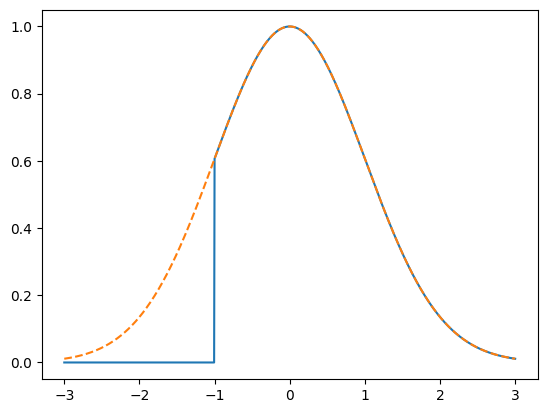

In [1]:
%load_ext autoreload
%autoreload 2
import jax
from jax import numpy as jnp
from gaussian_toolbox import pdf
from gaussian_toolbox import measure
from gaussian_toolbox.experimental import truncated_measure
import matplotlib.pyplot as plt

R = 1
D = 1

m = measure.GaussianMeasure(Lambda=jnp.ones((R, D, D)), nu=jnp.zeros((R, D)))
tm = truncated_measure.TruncatedGaussianMeasure(measure=m, lower_limit=-1)
#tm = truncated_measure.TruncatedGaussianMeasure(measure=m, upper_limit=1)
k = jnp.array([jnp.linspace(-3, 3, 1000)]).T

plt.plot(k[:,0], tm(k)[0])
plt.plot(k[:,0], m(k)[0], '--')

In [2]:
tp = tm.get_density()
tp.integrate()

Array([1.], dtype=float32)

In [3]:
tp.get_mean()

Array([[0.28759998]], dtype=float32)

In [4]:
tp.get_variance()

Array([[0.62968624]], dtype=float32)

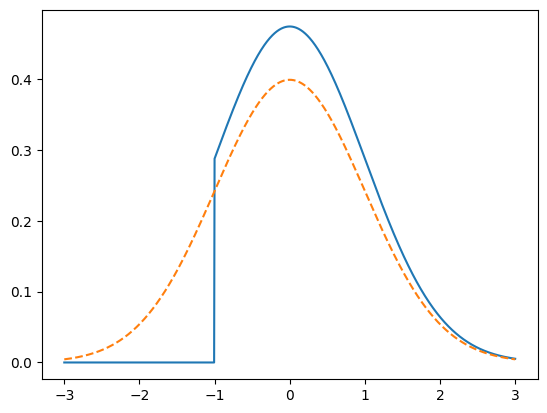

In [5]:
plt.plot(k[:,0], tp(k)[0])
plt.plot(k[:,0], tp.measure(k)[0], '--')

In [6]:
from jax.scipy.stats import norm
norm.pdf(jnp.inf)

Array(0., dtype=float32, weak_type=True)

In [7]:
tp.measure.Sigma

Array([[[1.]]], dtype=float32)

In [8]:
import numpy as np
def create_instance(R, lower, upper):
    D = 1
    Lambda = jnp.array(np.random.rand(R, D, D) + 1e-3)
    nu = jnp.array(np.random.rand(R, D))
    m = measure.GaussianMeasure(Lambda=Lambda, nu=nu)
    tm = truncated_measure.TruncatedGaussianMeasure(measure=m, lower_limit=lower, upper_limit=upper)
    return tm, m

R, lower, upper = 10, 0, None
for int_str in ["1", "x", "x**2"]:
    tm, m = create_instance(R, lower, upper)
    if int_str == "1":
        assert jnp.all(jnp.less(tm.integrate(int_str), m.integrate(int_str)))
    if upper is not None:
        tm1 = truncated_measure.TruncatedGaussianMeasure(measure=m, lower_limit=None, upper_limit=upper)
        tm2 = truncated_measure.TruncatedGaussianMeasure(measure=m, lower_limit=upper, upper_limit=None)
        if int_str == "x**2":
            assert jnp.allclose(tm1.integrate(int_str) + tm2.integrate(int_str), m.integrate("xx'")[:,0])
        else:
            assert jnp.allclose(tm1.integrate(int_str) + tm2.integrate(int_str), m.integrate(int_str))
        

In [9]:
tm1.integrate(int_str) #+ tm2.integrate(int_str)
tm1.integrate("x")

NameError: name 'tm1' is not defined

In [92]:
tm1.integrate(int_str) + tm2.integrate(int_str), m.integrate("xx'")

(Array([[5.5824733]], dtype=float32), Array([[[5.5824733]]], dtype=float32))

In [135]:
tm._expectation_integral().shape
tm.alpha.shape

(2, 1)

In [78]:
m.integrate("xx'")[:,0]

Array([[3.7440986e+08]], dtype=float32)

In [79]:
tm1.integrate(int_str) + tm2.integrate(int_str)

Array([[17490402.]], dtype=float32)

In [80]:
tm.lower_limit, tm.upper_limit

(Array([[-1.]], dtype=float32), Array([[2.]], dtype=float32))

In [98]:
from scipy.stats import truncnorm
truncnorm.var(lower, upper, m.mu, jnp.sqrt(m.Sigma))

array([[[0.8761674]]])

In [97]:
tm = truncated_measure.TruncatedGaussianMeasure(measure=m, lower_limit=lower, upper_limit=upper)
tm._get_variance()

Array([[0.6167051]], dtype=float32)

In [106]:

truncnorm.mean(a=a, b=b, loc=m.mu[:,0], scale=jnp.sqrt(m.Sigma[:,0,0]))

array([0.36709434])

In [107]:
tm._expectation_x()

Array([[0.3670944]], dtype=float32)

In [151]:
def create_instance(R, lower, upper):
    D = 1
    Lambda = jnp.array(np.random.rand(R, D, D) + 1e-3)
    nu = jnp.array(np.random.rand(R, D))
    m = measure.GaussianMeasure(Lambda=Lambda, nu=nu)
    tm = truncated_measure.TruncatedGaussianMeasure(measure=m, lower_limit=lower, upper_limit=upper)
    tp = tm.get_density()
    return tp, tp.density

def _get_scipy_params(self, d, lower, upper):
    loc, scale = d.mu[:,0], jnp.sqrt(d.Sigma[:,0,0])
    a, b = (lower - loc) / scale, (upper - loc) / scale
    return loc, scale, a, b


R, lower, upper = 2, 0, 1
tp, d = create_instance(R, lower, upper)

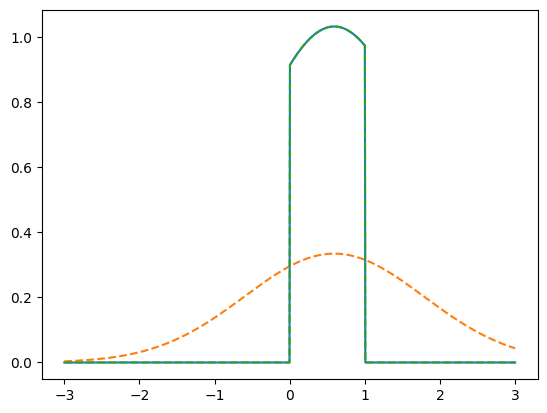

In [183]:
#tm = truncated_measure.TruncatedGaussianMeasure(measure=m, upper_limit=1)
k = jnp.array([jnp.linspace(-3, 3, 1000)]).T
loc, scale = d.mu[:,0], jnp.sqrt(d.Sigma[:,0,0])
alpha, beta = (lower - loc) / scale, (upper - loc) / scale
plt.plot(k[:,0], tp(k)[0])
plt.plot(k[:,0], d(k)[0], '--')
plt.plot(k[:,0], truncnorm.pdf(k[:,0], a=alpha, b=beta, loc=loc, scale=scale), '--')

In [184]:
jnp.allclose(tp(k), truncnorm.pdf(k[:,0], a=alpha, b=beta, loc=loc, scale=scale))

Array(True, dtype=bool)

In [230]:
truncnorm.moment(4, a=alpha[0], b=beta[0], loc=loc[0], scale=scale[0])

0.20087715025221536

In [15]:
from jax.scipy.stats.norm import pdf, cdf
from jax.lax import scan
from jax.scipy.special import gammaln

def binom(k, i):
  return jnp.array(jnp.round(jnp.exp(gammaln(k + 1) - gammaln(i + 1) - gammaln(k - i + 1))), dtype=int)

R, lower, upper = 2, 0, 1
tp, d = create_instance(R, lower, upper)
loc, scale = d.mu[:,0], jnp.sqrt(d.Sigma[:,0,0])
alpha, beta = (lower - loc) / scale, (upper - loc) / scale
denominator = cdf(beta) - cdf(alpha)

def scan_function(carry, k):
    L2, L1 = carry
    beta_pdf = jnp.where(jnp.isfinite(tp.beta[:,0]), tp.beta[:,0] ** (k - 1) * norm.pdf(tp.beta[:,0]), 0)
    alpha_pdf = jnp.where(jnp.isfinite(tp.alpha[:,0]), tp.alpha[:,0]  ** (k - 1) * norm.pdf(tp.alpha[:,0]), 0)
    L_new = - (beta_pdf - alpha_pdf) / denominator + (k - 1) * L2
    print(alpha_pdf.shape, beta_pdf.shape,L_new.shape, L2.shape, L1.shape)
    return (L1, L_new), L_new

order = 4
L0, L1 = jnp.ones((R,)), - (pdf(tp.beta[:,0]) - pdf(tp.alpha[:,0])) / denominator
Ls = scan(scan_function, (L0, L1), jnp.arange(2, order + 1))[1]
Ls = jnp.concatenate([L0[None], L1[None], Ls], axis=0)
k_range = jnp.arange(0, order + 1)[:,None]
Ls.shape, k_range.shape
jnp.cumsum(binom(order, k_range) * jnp.sqrt(tp.density.Sigma[:,:,0].T) ** k_range * tp.density.mu.T ** (order - k_range) * Ls, axis=0).shape
#jnp.cumsum(binom(order, k_range) * jnp.sqrt(tp.density.Sigma[:,:,0]) ** k_range * tp.density.mu ** (order - k_range) * Ls, axis=0).shape

(2,) (2,) (2,) (2,) (2,)


(5, 2)

In [33]:
from scipy.stats import truncnorm
def create_instance(R, lower, upper):
    D = 1
    Lambda = jnp.array(np.random.rand(R, D, D) + 1e-3)
    nu = jnp.array(np.random.rand(R, D))
    m = measure.GaussianMeasure(Lambda=Lambda, nu=nu)
    tm = truncated_measure.TruncatedGaussianMeasure(measure=m, lower_limit=lower, upper_limit=upper)
    tp = tm.get_density()
    return tp, tp.density

def _get_scipy_params(d, lower, upper):
    loc, scale = d.mu[:,0], jnp.sqrt(d.Sigma[:,0,0])
    a, b = (lower - loc) / scale, (upper - loc) / scale
    return loc, scale, a, b

R, lower, upper = 2, 0, 1
tp, d = create_instance(R, lower, upper)
if lower is None:
    lower = -jnp.inf
elif upper is None:
    upper = jnp.inf
loc, scale, a, b = _get_scipy_params(d, lower, upper)
for order in range(1, 5):
    print(order)
    moments = tp.integrate("x**k", k=order)
    for r in range(R):
        assert jnp.allclose(moments[r], truncnorm.moment(order , a=a[r], b=b[r], loc=loc[r], scale=scale[r]), atol=1e-5)

1
(2,) (2,) (2,) (2,) (2,)
(2,) (2,)
(2,) (2,) (2,) (2,) (2,)
2
(2,) (2,) (2,) (2,) (2,)
(2,) (2,)
(2,) (2,) (2,) (2,) (2,)
3
(2,) (2,) (2,) (2,) (2,)
(2,) (2,)
(2,) (2,) (2,) (2,) (2,)
4
(2,) (2,) (2,) (2,) (2,)
(2,) (2,)
(2,) (2,) (2,) (2,) (2,)


In [32]:
moments, truncnorm.moment(order , a=a[r], b=b[r], loc=loc[r], scale=scale[r])

(Array([[0.35887736],
        [0.39227295]], dtype=float32),
 0.39226046579380486)

In [11]:
r = 1
loc, scale = d.mu[:,0], jnp.sqrt(d.Sigma[:,0,0])
alpha, beta = (lower - loc) / scale, (upper - loc) / scale
truncnorm.moment(4, a=alpha[r], b=beta[r], loc=loc[r], scale=scale[r])

NameError: name 'truncnorm' is not defined

In [24]:
from jax.scipy.stats.norm import pdf, cdf
from jax.scipy.special import gammaln

def binom(k, i):
  return jnp.array(jnp.round(jnp.exp(gammaln(k + 1) - gammaln(i + 1) - gammaln(k - i + 1))), dtype=int)

R, lower, upper = 2, 0, 1
tp, d = create_instance(R, lower, upper)

order = 4
denominator = cdf(beta) - cdf(alpha)
L = [jnp.array([[1.]]), - (pdf(tp.beta) - pdf(tp.alpha)) / denominator] 
# scan function
for k in range(2, order + 1):
    beta_pdf = jnp.where(jnp.isfinite(tp.beta), tp.beta ** (k - 1) * norm.pdf(tp.beta), 0)
    alpha_pdf = jnp.where(jnp.isfinite(tp.alpha), tp.alpha  ** (k - 1) * norm.pdf(tp.alpha), 0)
    L.append(- (beta_pdf - alpha_pdf) / denominator + (k - 1) * L[-2])
    
L = jnp.concatenate(L)
k_range = jnp.arange(0, order + 1)[:,None]
jnp.cumsum(binom(order, k_range) * jnp.sqrt(tp.density.Sigma[:,:,0]) ** k_range * tp.density.mu ** (order - k_range) * L, axis=0)


TypeError: Cannot concatenate arrays with shapes that differ in dimensions other than the one being concatenated: concatenating along dimension 0 for shapes (1, 1), (2, 2), (2, 2), (2, 2), (2, 2).

In [234]:
L.shape

(9, 1)

In [201]:
from scipy.special import binom


1.0

In [187]:
from jax.scipy.stats import norm


h = tp.density.mu / jnp.sqrt(tp.density.Sigma[:,:,0])
rho = norm.pdf() / norm.cdf(-h)

SyntaxError: invalid syntax (1971628249.py, line 2)

In [180]:
R = 1
tp, d = create_instance(R, lower, upper)

pA = tp(tp.lower_limit, element_wise=True)
pB = tp(tp.upper_limit, element_wise=True)

probs = jnp.vstack([pA, -pB])


(2, 1)

In [ ]:
def get_moment(tp, order):
    def n_th_moment(order, alpha, beta):
        """
        Returns n-th moment. Defined only if n >= 0.
        Function cannot broadcast due to the loop over n
        """
        pA = tp(tp.lower_limit),
        pB = tp(tp.upper_limit)
        probs = [pA, -pB]
        moments = [0, 1]
        for k in range(1, n+1):
            # a or b might be infinite, and the corresponding pdf value
            # is 0 in that case, but nan is returned for the
            # multiplication.  However, as b->infinity,  pdf(b)*b**k -> 0.
            # So it is safe to use _lazywhere to avoid the nan.
            vals = _lazywhere(probs, [probs, [alpha, beta]],
                                lambda x, y: x * y**(k-1), fillvalue=0)
            mk = np.sum(vals) + (k-1) * moments[-2]
            moments.append(mk)
        return moments[-1]